<a href="https://colab.research.google.com/github/alexandre858/DataMinig/blob/main/Projet_implemente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Annotation et classification**

Ce programme permet, depuis un fichier csv et des images, de créer un dossier et un fichier json qui associera à chaque image des données.

Les données sont les suivantes:

      "name": nom de l'image
      "size_high": hauteur de l'image
      "size_lenght": largeur de l'image
      "format": format de l'image
      "red": taux de presence dans l'image du rouge
      "green": taux de presence dans l'image du vert
      "blue": taux de presence dans l'image du bleu
      "col_dom_r": canal rouge de la couleur dominante
      "col_dom_g": canal vert de la couleur dominante
      "col_dom_b": canal bleu de la couleur dominante
      "int_col_dom_r": interval du canal rouge dans le quel se situe la couleur dominante rouge
      "int_col_dom_g": interval du canal vert dans le quel se situe la couleur dominante vert
      "int_col_dom_b": interval du canal bleu dans le quel se situe la couleur dominante bleu
      "Type1": type primaire du pokémon
      "Type2": type secondaire du pokémon

In [ ]:
import os,sys
import json
import pathlib
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plot
import numpy
import math
from sklearn.cluster import MiniBatchKMeans

#Création dossier data
try:
   os.mkdir('data')
except:
    pass

donnees = {}
 
path = '.'

files = sorted(os.listdir(path+"/images"))

#Trie et manipulation du fichier csv
#---------------------------------------------------
df = pd.read_csv(path+"/pokemon.csv")
df.shape


df2 = df.sort_values(by=['Name'], ascending=True).reset_index(drop=True)

img_name = sorted(os.listdir(path+'/images'))
img_paths = []

for i in img_name:
    img_paths.append(path+i)

df2['adresses'] = img_paths
#---------------------------------------------------

#Parcour les images du dossier
i=1
for name in files:
  type1 = ""
  type2 = ""

  #Vérification qu'il s'agit bien d'un fichier et non d'un dossier
  if os.path.isfile("images/"+name):
    imgfile = Image.open("images/"+name)


    #Algoritme qui détermine la couleur dominante d'une image 
    #Utilisation de MiniBatchKmeans
    #---------------------------------------------------
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    if (len(numarray.shape)==2):

      cluster_count = 5

      clusters = MiniBatchKMeans(n_clusters=cluster_count)
      clusters.fit(numarray)

      npbins = numpy.arange(0, cluster_count+1)
      histogram = numpy.histogram(clusters.labels_, bins=npbins)

      #Récupération de l'index du max de l'histogram 

      #(La première couleur dominate est noir car l'image n'a pas d'arriere plan
      #et les pixel sont donc considéré comme noir par l'algorithme donc on ne la 
      #récupère pas, on concidère que la deuxième)
      index_max = numpy.where(histogram[0]==max(histogram[0]))

      histogram[0][index_max] = 0

      index_max = numpy.where(histogram[0]==max(histogram[0]))

      #Récupaération de la valeur de chaque canaux de la couleur dominate
      col_dom_r = math.ceil(clusters.cluster_centers_[index_max[0][0]][0])
      col_dom_g = math.ceil(clusters.cluster_centers_[index_max[0][0]][1])
      col_dom_b = math.ceil(clusters.cluster_centers_[index_max[0][0]][2])

    #Si il s'agit d'une image monochromatique
    else:
      col_dom_r = 500
      col_dom_g = 500
      col_dom_b= 500
    #---------------------------------------------------


    #Découpage et assosiation des couleurs à un interaval de couleur
    #---------------------------------------------------
    list_col=[col_dom_r, col_dom_g, col_dom_b]
    interval_r = 0
    interval_g = 0
    interval_b = 0
    list_int_col = [interval_r, interval_g, interval_b]

    #Découpage en 8 intervals
    inter=[range(0,32), range(32,64), range(64,96), range(96,128), range(128,160), range(160,192), range(192,224), range(224,257)]

    for i in range (0,3):
      if (list_col[i] in inter[0]):
        list_int_col[i] = 0

      elif (list_col[i] in inter[1]):
        list_int_col[i] = 1

      elif (list_col[i] in inter[2]):
        list_int_col[i] = 2

      elif (list_col[i] in inter[3]):
        list_int_col[i] = 3

      elif (list_col[i] in inter[4]):
        list_int_col[i] = 4

      elif (list_col[i] in inter[5]):
        list_int_col[i] = 5

      elif (list_col[i] in inter[6]):
        list_int_col[i] = 6

      elif (list_col[i] in inter[7]):
        list_int_col[i] = 7

      else:
        #Si monochromatique
        list_int_col[i]="NaN"
    #---------------------------------------------------


    #Analyse taux de présence couleurs
    #---------------------------------------------------
    histogram = imgfile.histogram()

    if (len(histogram)==1024 or len(histogram)==768):

      red = histogram[0:255]
      green = histogram[256:511]
      blue = histogram[512:767]

      total_red=0
      total_blue=0
      total_green=0

      j=0
      #Calcul du taux de présence pour chaque couleur
      #Plus la nuance est élevé plus elle a du poids (coefficient élevé)
      while j <255:
        total_red=total_red+red[j]*j
        total_blue=total_blue+blue[j]*j
        total_green=total_green+green[j]*j
        j+=1

    #Si monochrome
    else:
      total_red = 0
      total_green = 0
      total_blue = 0
    #---------------------------------------------------


    #Récupération des données sur le format de l'image
    #---------------------------------------------------
    hauteur=imgfile.size[0]
    largeur=imgfile.size[1]
    format=imgfile.format
    #---------------------------------------------------


    #mise en place des données dans un fichier json
    #---------------------------------------------------
    dele=4
    if (imgfile.format=="JPEG"):
      dele=5

    #Récupération des types
    for index,  row in df2.iterrows():
      if name == row["Name"]+".png":
        type1 = row["Type1"]
        type2 = row["Type2"]

    #Mise en place de toutes les informations dans la variable "donness"
    donnees[name]={"name":name[:-dele], "size_high":hauteur,
                    "size_lenght":largeur, "format":format,
                      "red":total_red,"green":total_green,"blue":total_blue,
                        "col_dom_r":col_dom_r, "col_dom_g":col_dom_g, "col_dom_b":col_dom_b,
                          "int_col_dom_r":list_int_col[0], "int_col_dom_g":list_int_col[1], "int_col_dom_b":list_int_col[2],
                            "Type1":type1, "Type2":type2}

    i=i+1 

#Création du fichier json et importation de la variable "donnees" dans le fichier
with open("data/data.json", "w") as file:
    json.dump(donnees, file,indent = 3)
#---------------------------------------------------


**Visualisation des information de la base d'image**

Ce programme permet de visualiser la quantité d'image associée à chaque type (primaire et secondaire)
Il permet aussi de visualiser 3 histograms qui affichent toutes les nuance d'un des canaux de toutes les couleurs dominantes.
Il permet aussi d'afficher un histogram du taux de présence d'un canal dans chaque images

           Typ
         count
Type1         
            88
Bug         63
Dark        28
Dragon      24
Electric    36
Fairy       17
Fighting    25
Fire        47
Flying       3
Ghost       23
Grass       66
Ground      30
Ice         23
Normal      93
Poison      28
Psychic     47
Rock        41
Steel       22
Water      105
           Typ
         count
Type2         
            88
Bug          3
Dark        16
Dragon      14
Electric     6
Fairy       18
Fighting    19
Fire         9
Flying      87
Ghost       12
Grass       18
Ground      30
Ice         10
Normal       4
Poison      31
Psychic     27
Rock        14
Steel       19
Water       13
nan        371


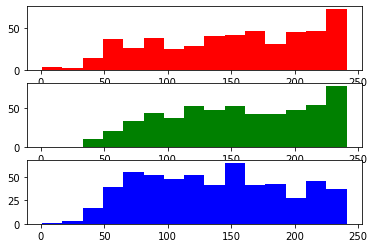

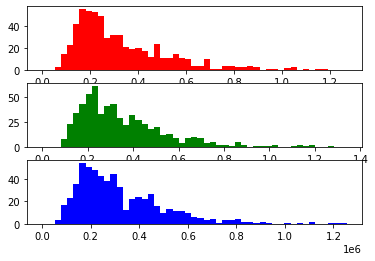

In [232]:
import matplotlib.pyplot as plot
import math
import json
from pandas.io.json import json_normalize
import pandas as pd

#Ouverture du fichier json contenant les données liées à chaque images
jsondata = json.load(open('data/data.json'))
list_col = ["col_dom_r","col_dom_g","col_dom_b","red","green","blue"]

list_dom_r=[]
list_dom_g=[]
list_dom_b=[]

list_r=[]
list_g=[]
list_b=[]

list_list=[list_dom_r,list_dom_g,list_dom_b,list_r,list_g,list_b]

array = []
array2=[]

#Récupération des Type primaires et secondaires de chaques images
for data in jsondata:
  array.append([jsondata[data]["Type1"],jsondata[data]["Type1"]])
  array2.append([jsondata[data]["Type2"],jsondata[data]["Type2"]])

  #Récupération des la couleur dominantes 
  #et du taux de présence de couleurs de chaque images
  for i in range (0,6):
    list_list[i].append(jsondata[data][list_col[i]])

#Création d'un tableau de type pandas regroupant les information de "Type1"
dataframe = pd.DataFrame(array,columns=["Type1","Typ"]) 

dataframe = dataframe.astype(dtype= {"Type1" : "<U200","Typ" : "<U200"})

#Regroupement par type secondaire
grouped = dataframe.groupby(["Type1"]).agg(["count"])

#Création d'un tableau de type pandas regroupant les information de "Type2"
dataframe2 = pd.DataFrame(array2,columns=["Type2","Typ"]) 

dataframe2 = dataframe2.astype(dtype= {"Type2" : "<U200","Typ" : "<U200"})

#Regroupement par type secondaire
grouped2 = dataframe2.groupby(["Type2"]).agg(["count"])

#Affichage du regroupement du type primaire et secondaire
print(grouped)
print(grouped2)

#Affichage histogram des couleur dominates
fig, axs = plot.subplots(3)
axs[0].hist(list_list[0],range(1,256,16),color='red')
axs[1].hist(list_list[1],range(1,256,16),color='green')
axs[2].hist(list_list[2],range(1,256,16),color='blue')
plot.show()
#Affichage histogram du taux de présences des canaux 
fig, axes = plot.subplots(3)
axes[0].hist(list_list[3],range(1,max(list_list[3]),math.ceil((max(list_list[3])-min(list_list[3]))/50)),color='red')
axes[1].hist(list_list[4],range(1,max(list_list[4]),math.ceil((max(list_list[4])-min(list_list[4]))/50)),color='green')
axes[2].hist(list_list[5],range(1,max(list_list[5]),math.ceil((max(list_list[5])-min(list_list[5]))/50)),color='blue')
plot.show()

**Simulation d'un utilisateur**

Ce programme choisis de manière àléatoire des images et affecte à certaines un "1" et pour d'autres un "0" de manière semi-aléatoire ou manuel selon.

1 représente un like et 0 ne représente rien.


In [242]:
from PIL import Image
import matplotlib.pyplot as plot
import matplotlib.image as mpimg
import json
from random import seed,random

#La seed permet d'executer toujours la même séquence aléatoire
seed(2)

#Saisie mode manu ou auto
n=int(input("Entrez 1 pour un choix manuel ou 0 pour auto :"))

manual_choice = False

if (n==1):
  manual_choice=True

  #saisie nombre d'image à proposer
  nb_image_to_like=int(input("Entrez le nombre d'images à proposer :"))

else:
  nb_image_to_like=10


#Création dossier data
try:
   os.mkdir('data')
except:
    pass

path='.'
files = os.listdir(path+"/images")

#Ouverture du fichier json contenant les données liées à chaque images
jsondata = json.load(open('data/data.json'))

i=0
for name in files:
  #Vérification qu'il s'agit bien d'un fichier et non d'un dossier
  if os.path.isfile("images/"+name):
    #Lorsque la saisie est en cours
    if (i<nb_image_to_like):
      #Si on choisis le mode manu
      if (manual_choice):
        #Affichage de l'image
        img = mpimg.imread("images/"+name)
        imgplot = plot.imshow(img)
        plot.show()

        n=int(input("Entrez 1 si vous aimez, ou 0 si non : "))

        #Ajout de l'attribut avec la valeur associée
        jsondata[name]["liked"]=n

        i=i+1

      else:
        #Génération d'un entier aléatoire qui vaut 0 ou 1
        n=round(random())

        #Ajout de l'attribut avec la valeur associée
        jsondata[name]["liked"]=n
        i=i+1

    else:
      #Si la saisie est terminée
      jsondata[name]["liked"]="NaN"

#Mise en place des données dans une variables puis création d'un fichier json
donnees=jsondata

with open("data/data_liked.json", "w") as file:
    json.dump(donnees, file,indent = 3)


Entrez 1 pour un choix manuel ou 0 pour auto :0


**Traitement des images aimées et Classement des images de la base d'image**

Ce programme permet de définir quel type de suggestion l'utilisateur veut faire à l'aide de balises (par types, par format, par couleur ou automatiquement (tous))

Ce programme traite, par la suite, les images qui ont été aimées en récupérent:

1.   La moyenne des couleur dominante aimées
2.   Les type primaire et secondaire aimé,
3.   Le format qui est aimé.

Il classe ensuite toutes les autres images selon leur pertinance à l'aide d'un système de point, plus la variable "point" d'une image est élevé plus l'image correspond à ce que l'utilisateur pourrait potentiellement aimer.





In [241]:
from collections import Counter 
import json

#List contenant les balises que l'utilisateur veut utiliser pour la suggestion
list_balise=[]

#tant que l'utilisateur ne rentre pas de balise valable la boucle recommence
while (("format" in list_balise or "type" in list_balise or "couleur" in list_balise or "auto" in list_balise)==False):
  n=input("Par quelle balise voulez vous trier: format, type, couleur (plusieurs choix possible) ou auto :")
  list_balise=n.split(" ")

#Balises
format = False
Type = False
color = False
auto = False

if ("format" in list_balise):
  format = True

if ("type" in list_balise):
  Type = True

if ("couleur" in list_balise):
  color = True

if ("auto" in list_balise):
  auto = True

#Ouverture du fichier json contenant information des images liked
jsondata = json.load(open('data/data_liked.json'))

moy_int_cd_r = 0
moy_int_cd_g = 0
moy_int_cd_b = 0
Nb = 0
list_type = []
Point = 0
list_all_types = []
nb_png = 0
nb_jpeg = 0
mono = 0

#Parcour de chaque image présent dans le json
for data in jsondata:
  #Récupération de la liste de tout les types primaires et secondaires différents possibles
  if (not(jsondata[data]["Type1"])in list_all_types and str(jsondata[data]["Type2"])!="nan" and jsondata[data]["Type2"]!=""):
    list_all_types.append(jsondata[data]["Type1"])

  if (not(jsondata[data]["Type2"]in list_all_types) and str(jsondata[data]["Type2"])!="nan" and jsondata[data]["Type2"]!=""):
    list_all_types.append(jsondata[data]["Type2"])

  #Si l'image est aimé
  if (jsondata[data]["liked"]==1):
    #Si l'image est monochromatique
    if (jsondata[data]["int_col_dom_r"]=="NaN"):
      mono += 1

    #Si non on récupère la valeur de la couleur dominante puis on la somme aux autres
    else:
      moy_int_cd_r = moy_int_cd_r + jsondata[data]["int_col_dom_r"]
      moy_int_cd_g = moy_int_cd_g + jsondata[data]["int_col_dom_g"]
      moy_int_cd_b = moy_int_cd_b + jsondata[data]["int_col_dom_b"]

    #Récupération des Type1 et Type2
    if (str(jsondata[data]["Type2"])!="nan" and jsondata[data]["Type2"]!=""):
      list_type.append(jsondata[data]["Type2"])

    if (jsondata[data]["Type1"]!=""):
      list_type.append(jsondata[data]["Type1"])

    #Récupération du nombre d'image étant au format PNG ou JPEG
    if (jsondata[data]["format"]=="PNG"):
      nb_png += 1

    if (jsondata[data]["format"]=="JPEG"):
      nb_jpeg += 1
    Nb+=1

#Calcule d
mono=mono/Nb

nb_type_list = len(list_type)

nb_png = nb_png/Nb
nb_jpeg = nb_jpeg/Nb

dict_type = Counter(list_type)

for i in dict_type:
  list_all_types.remove(i)
  dict_type[i] = dict_type[i]/nb_type_list

for i in list_all_types:
  dict_type[i] = 0


moy_int_cd_r = round(moy_int_cd_r/Nb)
moy_int_cd_g = round(moy_int_cd_g/Nb)
moy_int_cd_b = round(moy_int_cd_b/Nb)


point=0
for data in jsondata:
  point=0
  if (jsondata[data]["liked"]=="NaN"):
    if (color or auto):

      if(jsondata[data]["int_col_dom_r"]=="NaN"):
        point=mono

      else:

        if (jsondata[data]["int_col_dom_r"]==moy_int_cd_r):
          point+=1/3

        elif (moy_int_cd_r-1<=jsondata[data]["int_col_dom_r"]<=moy_int_cd_r+1):
          point+=1/6

        if (jsondata[data]["int_col_dom_g"]==moy_int_cd_g):
          point+=1/3

        elif (moy_int_cd_g-1<=jsondata[data]["int_col_dom_g"]<=moy_int_cd_g+1):
          point+=1/6

        if (jsondata[data]["int_col_dom_b"]==moy_int_cd_b):
          point+=1/3

        elif (moy_int_cd_b-1<=jsondata[data]["int_col_dom_b"]<=moy_int_cd_b+1):
          point+=1/6

    if (format or auto):

      if(jsondata[data]["format"]=="PNG"):
        point += nb_png

      if (jsondata[data]["format"]=="JPEG"):
        point += nb_jpeg

    if (Type or auto):
      
      point +=dict_type[jsondata[data]["Type1"]]
      point +=dict_type[jsondata[data]["Type2"]]

    jsondata[data]["point"]=point

donnees=jsondata
with open("data/data_point_suggestion.json", "w") as file:
    json.dump(donnees, file,indent = 3)




      

Par quelle balise voulez vous trier: format, type, couleur (plusieurs choix possible) ou auto :auto


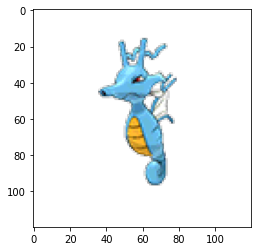

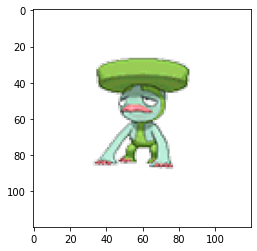

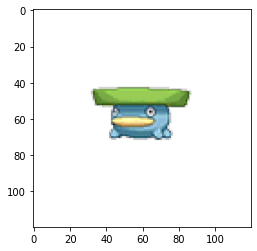

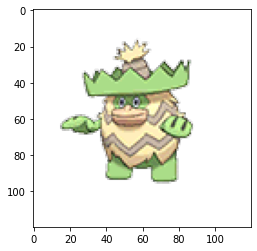

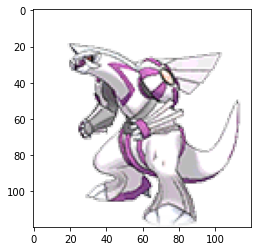

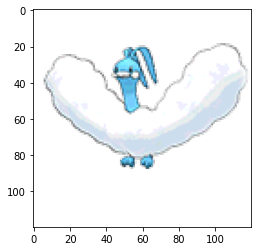

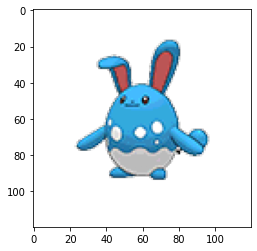

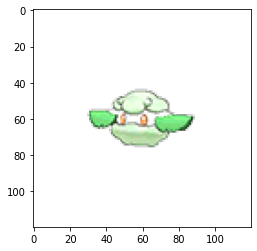

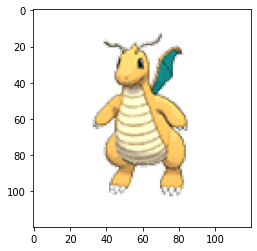

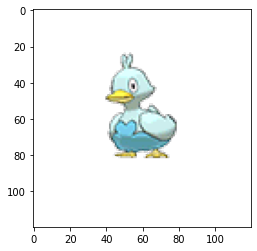

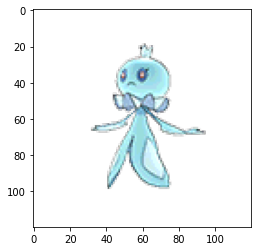

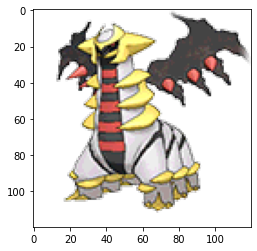

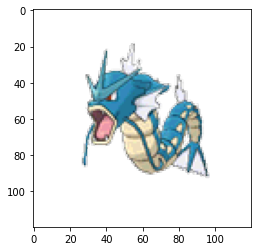

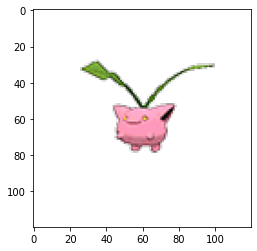

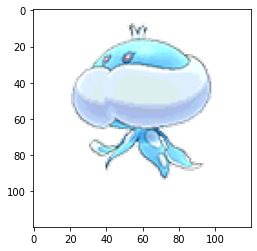

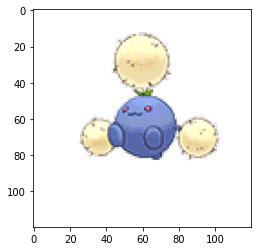

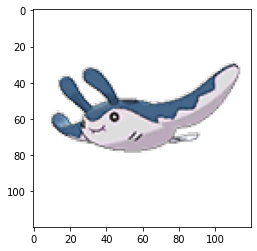

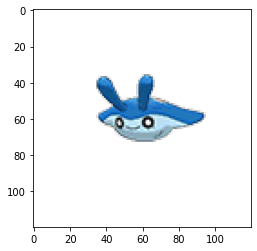

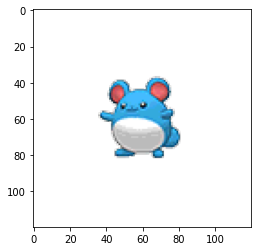

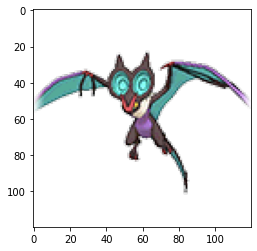

['kingdra.png', 'lombre.png', 'lotad.png', 'ludicolo.png', 'palkia.png', 'altaria.png', 'azumarill.png', 'cottonee.png', 'dragonite.png', 'ducklett.png', 'frillish.png', 'giratina-altered.png', 'gyarados.png', 'hoppip.png', 'jellicent.png', 'jumpluff.png', 'mantine.png', 'mantyke.png', 'marill.png', 'noivern.png']


In [ ]:
#algorithme suggestion
from pandas.io.json import json_normalize
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

jsondata = json.load(open('data/data_point_suggestion.json'))
list_point=[]
list_name=[]

list_suggestion=[]
for data in jsondata:
  if (jsondata[data]["liked"]=="NaN"):
    list_point.append(jsondata[data]["point"])
    list_name.append(data)

list_index_max=[]


for i in range (20):
  index=list_point.index(max(list_point))
  list_suggestion.append(list_name[index])
  list_point[index]=0

  img = mpimg.imread("images/"+list_name[index])
  imgplot = plt.imshow(img)
  plt.show()


print(list_suggestion)
